# <center>Деревья классификации</center>

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

Рассмотрим задачу бинарной классификации. Сгенерируем обучающую выборку и сохраним её в переменные `(train_data, train_labels)`. Каждый объект характеризуется парой признаков $x_1$ и $x_2$.

In [2]:
np.random.seed(67)
points = np.random.uniform(size=(20, 2), low=-1, high=1)
positive = points[np.logical_xor(points[:, 0] >= 0, points[:, 1] >= 0)]
negative = points[np.logical_xor(points[:, 0] >= 0, points[:, 1] < 0)]
train_data = np.vstack([positive, negative])
train_labels = np.hstack([np.ones(positive.shape[0]), np.zeros(negative.shape[0])])

In [3]:
train_data[:5]

array([[ 0.37178517, -0.33681636],
       [-0.57370028,  0.8650133 ],
       [ 0.4456366 , -0.90620939],
       [-0.91362246,  0.91001759],
       [-0.20464543,  0.05931678]])

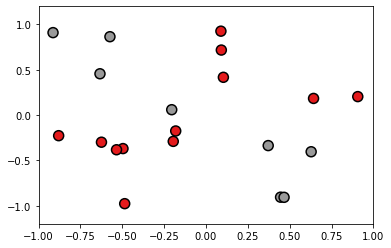

In [4]:
plt.scatter(train_data[:, 0], train_data[:, 1], 
            c=train_labels, s=100, cmap='Set1', edgecolors='black', linewidth=1.5)
plt.xlim(-1, 1)
plt.ylim(-1.2, 1.2)
plt.show()

**Задание 1.** Выберите предикаты, по которым проводить разбиение. Постройте дерево решений для данной задачи. Какой глубины будет оптимальное дерево?

In [5]:
#делим элементы на право-лево
X1_right = train_data[train_data[:, 0] > 0] # элементы справа
y1_right = train_labels[train_data[:, 0] > 0]

X1_left = train_data[train_data[:, 0] <= 0] # элементы слева
y1_left = train_labels[train_data[:, 0] <= 0]

In [6]:
#делим каждую половину на верз-низ
X2_right_u = X1_right[X1_right[:, 1] > 0] #право - верх
y2_right_u = y1_right[X1_right[:, 1] > 0]

X2_right_d = X1_right[X1_right[:, 1] <= 0] #право - низ
y2_right_d = y1_right[X1_right[:, 1] <= 0]


X2_left_u = X1_left[X1_left[:, 1] > 0] #лево - верх
y2_left_u  = y1_left[X1_left[:, 1] > 0]

X2_left_d = X1_left[X1_left[:, 1] <= 0] #лево - низ
y2_left_d = y1_left[X1_left[:, 1] <= 0]

In [7]:
y2_right_u,y2_right_d,y2_left_u ,y2_left_d

(array([0., 0., 0., 0., 0.]),
 array([1., 1., 1., 1.]),
 array([1., 1., 1., 1.]),
 array([0., 0., 0., 0., 0., 0., 0.]))

**Задание 2.** При построении деревьев классификации используются различные критерии информативности. Сравните начальную энтропию и начальное значение критерия Джини в данной задаче.

$$S_0=-p log_2 p-(1-p)log_2(1-p)$$
$$G_0=1-p^2-(1-p)^2$$

In [8]:
def S(p):
        return -p * np.log2(p) - (1 - p) * np.log2(1 - p)
def G(p):
    return 1 - p*p - (1-p)*(1-p)

In [9]:
p=np.count_nonzero(train_labels)/len(train_labels)
p

0.4

In [10]:
S(p)

0.9709505944546686

In [11]:
G(p)

0.48

**Задание 3.** Определите набор предикатов для данной задачи. Для этого напишите функцию, которая по значениям признака и целевой переменной возвращает список предикатов для выбранного признака. Получите все предикаты по **всем** признакам.

In [12]:
def predic(x,y):
    new_x=x[np.argsort(x)]
    new_y=y[np.argsort(x)]
    lst=[]
    for i in range(len(y)-1):
        if new_y[i]!=new_y[i+1]:
            lst.append((new_x[i]+new_x[i+1])/2)
    return np.array(lst)

In [13]:
pr1=predic(train_data[:, 0],train_labels) #1 признак
pr1

array([-0.8968133 , -0.75660659, -0.6287665 , -0.59901212, -0.55403723,
       -0.3450799 , -0.20007115,  0.23787043,  0.63547434])

In [14]:
pr2=predic(train_data[:, 1],train_labels) #2 признак
pr2

array([-0.94274591, -0.39375319, -0.35333149, -0.31808827, -0.05808716,
        0.12152789,  0.43647297,  0.58685395,  0.79136326,  0.91809101])

**Задание 4.** Для каждого полученного в задании 3 предиката вычислите прирост информации (IG) по **критерию Джини**. Какое правило предлагает поместить в корень дерева указанный критерий? Проведите такое разбиение.

In [15]:
def find_IG(num_pr,n,train_labels,train_data):
    lst=[]
    for i in range(len(num_pr)):
        X_right = train_data[train_data[:, n] > num_pr[i]]
        y_right = train_labels[train_data[:, n] > num_pr[i]]

        X_left = train_data[train_data[:, n] <= num_pr[i]]
        y_left = train_labels[train_data[:, n] <= num_pr[i]]

        if len(y_right)!=0:
            p1_r=np.count_nonzero(y_right)/len(y_right)
        else:
            p1_r=0
            
        if len(y_left)!=0:
            p1_l=np.count_nonzero(y_left)/len(y_left)
        else:
            p1_l=0
            
        p_r=len(y_right)/len(train_labels)
        p_l=len(y_left)/len(train_labels)
        p=np.count_nonzero(train_labels)/len(train_labels)

        IG=G(p)-(p_r*G(p1_r)+p_l*G(p1_l))
        lst.append(IG)

    return np.max(lst),num_pr[np.argsort(lst)][-1]

In [16]:
find_IG(pr1,0,train_labels,train_data) #прирост информации и предикат для признака 1

(0.06095238095238098, 0.2378704257933334)

In [17]:
find_IG(pr2,1,train_labels,train_data) #прирост информации и предикат для признака 2

(0.06124999999999997, -0.3937531883073182)

Найдем предикат который дает наилучший прирост информации среди признаков

In [18]:
def find_best(r1,r2):
    if r1[0]>=r2[0]:
        return r1[1],0
    else:
        return r2[1],1

In [19]:
new_pr=find_best(find_IG(pr1,0,train_labels,train_data),find_IG(pr2,1,train_labels,train_data))
new_pr #предикат и по какому признаку

(-0.3937531883073182, 1)

In [20]:
#Разбиваем дерево в соответствии с новым предикатом
X_right = train_data[train_data[:, new_pr[1]] > new_pr[0]]
y_right = train_labels[train_data[:, new_pr[1]] > new_pr[0]]

X_left = train_data[train_data[:, new_pr[1]] <= new_pr[0]]
y_left = train_labels[train_data[:, new_pr[1]] <= new_pr[0]]

In [21]:
y_right,y_left

(array([1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 array([1., 1., 1., 0.]))

**Задание 5.** Постройте решающее дерево той же глубины, что и в задании 1. С помощью полученного дерева классифицируйте объект с признаками (0.5, 0.3).

In [22]:
#находим критерий джинни для правой и левой части дерева
p_r=np.count_nonzero(y_right)/len(y_right)
G(p_r)

0.4296875

In [23]:
p_l=np.count_nonzero(y_left)/len(y_left)
G(p_l)

0.375

### Правое поддерево

In [24]:
find_IG(pr1,0,y_right,X_right) #прирост информации и предикат для признака 1 правого поддерава

(0.07514204545454539, -0.554037228654128)

In [25]:
find_IG(pr2,1,y_right,X_right) #прирост информации и предикат для признака 2 правого поддерава

(0.07514204545454539, 0.43647296726164697)

In [26]:
new_pr_r=find_best(find_IG(pr1,0,y_right,X_right),find_IG(pr2,1,y_right,X_right))
new_pr_r

(-0.554037228654128, 0)

In [27]:
#делим правое поддерево
X2_right_u = X_right[X_right[:, new_pr_r[1]] > new_pr_r[0]]
y2_right_u = y_right[X_right[:, new_pr_r[1]] > new_pr_r[0]]

X2_right_d = X_right[X_right[:, new_pr_r[1]] <= new_pr_r[0]] 
y2_right_d = y_right[X_right[:, new_pr_r[1]] <= new_pr_r[0]]

In [28]:
y2_right_u ,y2_right_d

(array([1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 array([1., 1., 1., 0., 0.]))

### Левое поддерево

In [29]:
find_IG(pr1,0,y_left,X_left) #прирост информации и предикат для признака 1 левого поддерава

(0.375, 0.2378704257933334)

In [30]:
find_IG(pr2,1,y_left,X_left) #прирост информации и предикат для признака 2 левого поддерава

(0.375, -0.9427459061178219)

In [31]:
new_pr_l=find_best(find_IG(pr1,0,y_left,X_left),find_IG(pr2,1,y_left,X_left))
new_pr_l

(0.2378704257933334, 0)

In [32]:
# делим левое поддерево
X2_left_u = X_left[X_left[:, new_pr_l[1]] >= new_pr_l[0]]
y2_left_u = y_left[X_left[:, new_pr_l[1]] >= new_pr_l[0]]

X2_left_d = X_left[X_left[:, new_pr_l[1]] < new_pr_l[0]] 
y2_left_d = y_left[X_left[:, new_pr_l[1]] < new_pr_l[0]]

In [33]:
y2_left_u ,y2_left_d

(array([1., 1., 1.]), array([0.]))

### Итоговое дерево

In [34]:
y2_right_u ,y2_right_d,y2_left_u ,y2_left_d

(array([1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 array([1., 1., 1., 0., 0.]),
 array([1., 1., 1.]),
 array([0.]))

In [35]:
def define_class(lis):
    if len(lis[lis==1])>len(lis[lis==0]):
        return 1
    else:
        return 0

#### Определяем класс вершин

In [36]:
v_r_u,v_r_d = define_class(y2_right_u),define_class(y2_right_d)
v_l_u,v_l_d = define_class(y2_left_u),define_class(y2_left_d)

In [37]:
v_r_u,v_r_d,v_l_u,v_l_d

(0, 1, 1, 0)

То есть право-верх класс 0, право низ класс 1, лево врех класс 1, лево низ класс 0

# С помощью полученного дерева классифицируйте объект с признаками (0.5, 0.3).

In [38]:
obj=[0.5,0.3]

In [39]:
if obj[new_pr[1]] > new_pr[0]:
    if obj[new_pr_r[1]]>new_pr_r[0]:
        print('Объект класса:',v_r_u)
    else:
        print('Объект класса:',v_r_d)
else:
    if obj[new_pr_l[1]]>new_pr_l[0]:
        print('Объект класса:',v_l_u)
    else:
        print('Объект класса:',v_l_d)

Объект класса: 0


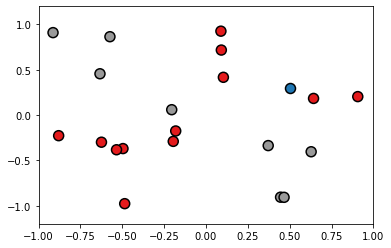

In [40]:
plt.scatter(train_data[:, 0], train_data[:, 1], 
            c=train_labels, s=100, cmap='Set1', edgecolors='black', linewidth=1.5)
plt.xlim(-1, 1)
plt.ylim(-1.2, 1.2)
plt.scatter(0.5,0.3, s=100, cmap='Set1', edgecolors='black', linewidth=1.5)
plt.show()

**Задание 6*.** Постройте решающее дерево максимальной глубины, пользуясь критерием Джини. Какой глубины получилось дерево? Отобразите все предикаты на графике.